In [2]:
import torch
import torchvision
torch.__version__, torchvision.__version__

('2.2.1+cu121', '0.17.1+cu121')

In [3]:
!ls


sample_data


In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[INFO] couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary
try:
  from going_modular.going_modular import data_setup, engine
except:
  print("[INFO] Couldn't find going_modular scripts... downloading then from GH.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

[INFO] couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading then from GH.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 33.48 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [5]:
# setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [7]:
# downloadint eh pizza-steak
import os
import zipfile
from pathlib import Path
import requests

data_path  = Path("data/")
image_path = data_path/"pizza_steak_sushi" #which can be described as a subset of data
if image_path.is_dir():
  print(f"{image_path} directory exisist, skipping re-download")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)
  # dowloading the data
  with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading the data")
    f.write(request.content)
  with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
    print("Unzipping data")
    zip_ref.extractall(image_path)
  os.remove(data_path/"pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi, downloading it...
Unzipping data


In [8]:
!ls

data  going_modular  sample_data


In [9]:
%%writefile going_modular/going_modular/download_data.py
"""
This file helps in the extraction of data from the github datasource and then using that to populate the data directory"""
import os
import zipfile
from pathlib import Path
import requests

def download_data(url:str):
  data_path  = Path("data/")
  image_path = data_path/"pizza_steak_sushi"
  if image_path.is_dir():
    print(f"{image_path} directory exisist, skipping re-download")
  else:
    print(f"Did not find {image_path}, downloading it...")
    image_path.mkdir(parents=True, exist_ok=True)
    # dowloading the data
    with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
      request = requests.get(url)
      print("Downloading the data")
      f.write(request.content)
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
      print("Unzipping data")
      zip_ref.extractall(image_path)
    os.remove(data_path/"pizza_steak_sushi.zip")


Writing going_modular/going_modular/download_data.py


In [10]:
train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

**Reference this manual pattern from here** https://pytorch.org/vision/0.12/models.html and take note of this
>All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape `(3 x H x W)`, where H and W are expected to be at least 224. The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. You can use the following transform to normalize:

In [11]:
# creating the datasets and Dataloaders
# turning the data into dataloasers
from torchvision import transforms
# manual pattern of creating the data transformations based on pretrained weights

normalize = transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])

manual_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize #attempting to perform regularization on the data to match pretrained model specs
])


In [12]:
from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform=manual_transforms,
    batch_size=32,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f8ca589b9d0>,
 ['pizza', 'steak', 'sushi'])

In [13]:
# using the automatic pattern
import torchvision
torchvision.__version__

'0.17.1+cu121'

In [14]:
# get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT #default referes to best performing weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [15]:
# get the transforms
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [16]:
# creating dataloader using automatic transforms

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform=auto_transforms,
    batch_size=32,
)

## Getting a pretrained Models
There are various places to get a pretrained models such as:
1. Pytorch domain libraries
2. Libraries like timm (torch image models)
3. HuggingFace Hub (For plenty of different models)
4. Paperswithcode(for models accross different problem spaces/domains)

**SInce this is an important model to use for the development of a tramsfer learning stly system for the model**
you can find more information about this here https://pytorch.org/hub/nvidia_deeplearningexamples_efficientnet/

In [26]:
# old method of using pretrained models
# model  = torchvision.models.efficientnet_b0(pretrained=True)
# new method is
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights = weights).to(device)


In [27]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [28]:
# getting the model's summary
from torchinfo import summary
summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size", "num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [29]:
# creating a new model on the pretrained
# works by freezing the base model and changing the output layers to suit out needs with a feature extractor

for param in model.features.parameters():
  param.requires_grad = False

In [30]:
from torch import nn
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=3,bias=True)
).to(device)

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =model.parameters(), lr=0.001)

In [33]:
from going_modular.going_modular import engine
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader =test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs=5,
                       device = device)
stop_time = timer()

print(f'[INFO] Total Training time: {stop_time-start_time:.3f} seconds')


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
[INFO] Total Training time: 183.066 seconds


In [35]:
from pathlib import Path
import requests
gm_path = Path("going_modular")

with open(gm_path/"going_modular/helper_functions.py", "wb") as f:
  print("downloading the helper functions ")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  f.write(request.content)

downloading the helper functions 


In [36]:
from going_modular.going_modular.helper_functions import plot_loss_curves

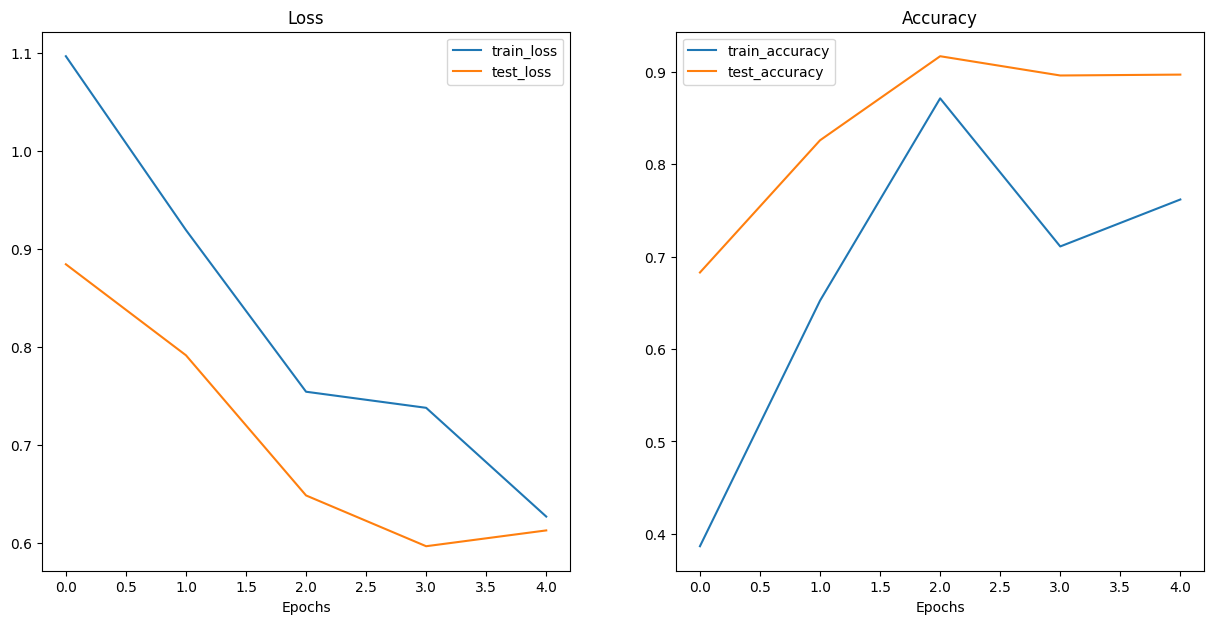

In [37]:
plot_loss_curves(results)

In [52]:
# making predictions on the test data
from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str],
                        image_size:Tuple[int,int] =(224,224),
                        transform:torchvision.transforms=None,
                        device:torch.device=device
                        ):
  img = Image.open(image_path)
  # creating a transform if it doesn extx
  if transform is not None:
    image_transform= transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize((image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225]
        )
    ])
  model.to(device)
  model.eval()
  with torch.inference_mode():
    # transform the image and add batch dimemsion
    transformed_image = image_transform(img).unsqueeze(dim=0)
    target_img_logits = model(transformed_image.to(device))
  target_img_pred = torch.softmax(target_img_logits,dim=1)
  target_label = torch.argmax(target_img_pred,dim=1)
  # performing the visualization of the image
  plt.figure(figsize=(10,4))
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_label]} | Prob:{target_img_pred.max():.2f}")
  plt.axis('off')






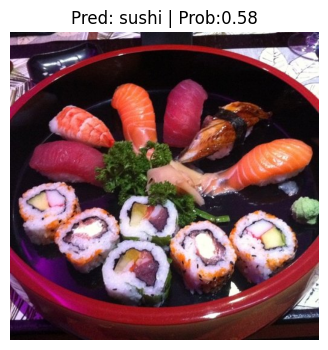

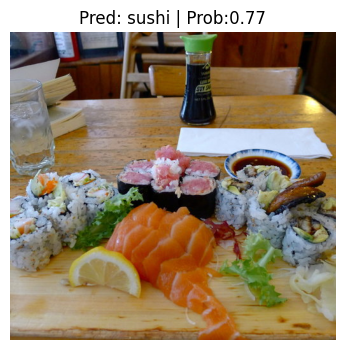

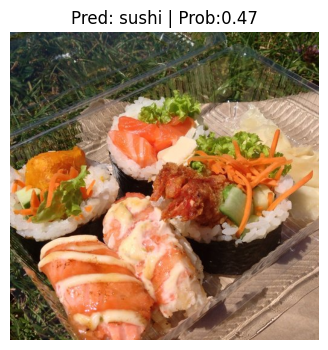

In [53]:
import random
num_images = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images)
for link in test_image_path_sample:
  pred_and_plot_image(model=model,
                        image_path=link,
                        class_names=class_names,
                        image_size=(224,224),
                        # transform=None,
                        # device=device
                        )



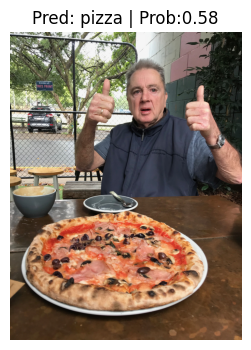

In [56]:
# downloading data image
with open('data.jpeg', "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
  f.write(request.content)

image_path = Path("data.jpeg")
pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224,224),
                        # transform=None,
                        # device=device
                        )


In [24]:
summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size", "num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1